In [1]:
#imports

import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gp
import geoplot as gplt
import geoplot.crs as gcrs
import contextily as ctx
from collections import Counter
from PIL import Image
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

OUTPUT = Path.cwd().parents[0] / "Output"
CRS_WGS = "epsg:4326"
CRS_PROJ = "epsg:3857"

#csv file of tweet data
df = pd.read_csv(Path.cwd().parents[0]  / "CSV" / "Raw"/ "all_tweets.csv")

#geodataframes for plotting spatial facet
eu = gp.read_file(Path.cwd().parents[0]/ "Europe_coastline_shapefile" / "eu_shp_4326.shp",crs =CRS_WGS)
gdf = gp.GeoDataFrame(df, geometry=gp.points_from_xy(df.long, df.lat),crs = CRS_PROJ)


#data cleaning and preparation

def clean_emoji(x):
    if x == '{}':
        return None
    else:
        return x[1:-1]

df['emoji'] = df['emoji'].apply(clean_emoji)
df['hashtags'] = df['hashtags'].apply(lambda x:x[1:-1])
df['post_publish_date'] = pd.to_datetime(df['post_publish_date']) 
df['Month/Year'] = df['post_publish_date'].dt.to_period('M') #aggregating timestamps to monthly intervals
df['Year'] = df['post_publish_date'].dt.year #aggregating timestamps to yearly intervals
df.drop(columns = ['post_guid'],inplace = True)
df

,long,lat,post_body,post_publish_date,post_language,hashtags,emoji,geometry,Month/Year,Year
0,9.159337,45.461345,L’esercito silenzioso delle #donne #migranti h...,2017-01-18 11:56:38,it,"migranti,donne",None,POINT (9.15934 45.46135),2017-01,2017
1,12.545146,41.898417,".@lauraravetto: #Migranti, “Che dice Minniti s...",2017-01-18 12:09:43,it,Migranti,None,POINT (12.54515 41.89842),2017-01,2017
2,-8.621914,41.162142,#refugeecrisis https://t.co/JQoSFvMTbl,2017-01-18 12:06:31,und,refugeecrisis,None,POINT (-8.62191 41.16214),2017-01,2017
3,12.545146,41.898417,".@lauraravetto : #Migranti, “Che dice Minniti ...",2017-01-18 12:07:41,it,Migranti,None,POINT (12.54515 41.89842),2017-01,2017
4,-2.115866,53.073712,""".@theresa_may: '""We can still have EU workers...",2017-01-18 12:17:35,en,"Brexit,PMQs,immigration",None,POINT (-2.11587 53.07371),2017-01,2017
...,...,...,...,...,...,...,...,...,...,...
168248,4.476774,50.501174,""". @JunckerEU '""We want to get rid of this id...",2017-01-18 11:05:00,en,"terrorism,Juncker,migration",None,POINT (4.47677 50.50117),2017-01,2017
168249,14.380054,35.934249,Malts should not be allowed to deal with #migr...,2017-01-18 11:22:18,en,"EU2017MT,migration",None,POINT (14.38005 35.93425),2017-01,2017
168250,-3.703508,40.477795,#RussianDissident Artist Will Seek #Asylum in ...,2017-01-18 11:17:53,en,"RussianDissident,Asylum",🇫🇷,POINT (-3.70351 40.47779),2017-01,2017
168251,1.357922,51.379483,Just caught this sight out of my bedroom windo...,2017-01-18 11:30:09,en,"Victory,Birds,Gaggle,VFlight,Margate,Geese,Mig...",😊,POINT (1.35792 51.37948),2017-01,2017


<GeoAxesSubplot:>

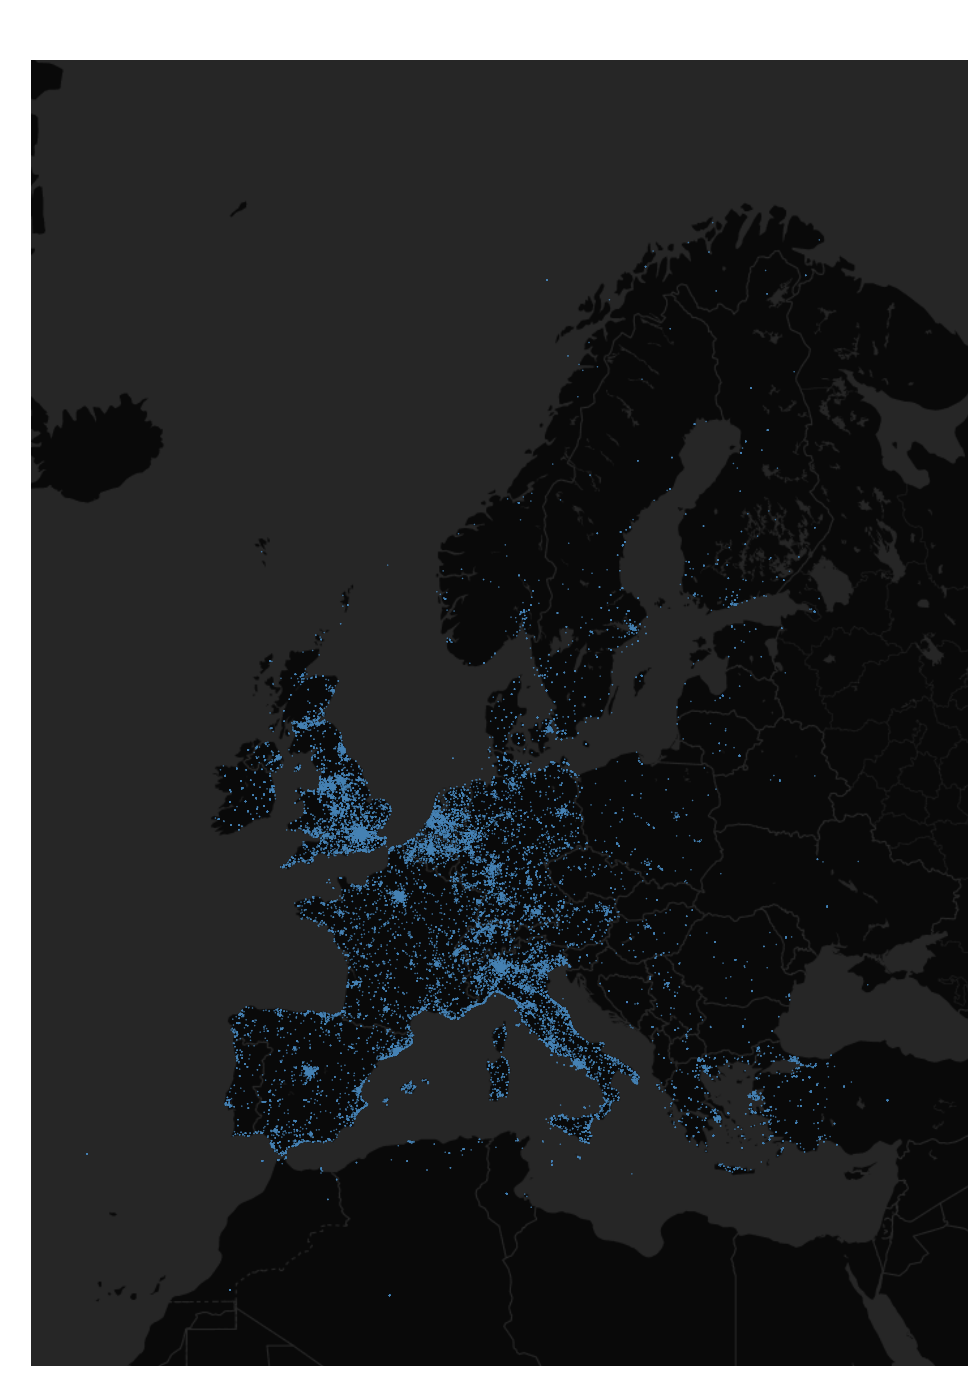

In [2]:
#let's plot the spatial facet first

ax = gplt.webmap(eu, projection=gcrs.WebMercator(),
                 provider = ctx.providers.CartoDB.DarkMatterNoLabels,
                 figsize =(35,25)) #basemap 


gplt.pointplot(gdf,
               ax = ax,
               s = 0.5) #location of all tweets within the dataset

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, '2017'),
  Text(1, 0, '2016'),
  Text(2, 0, '2018'),
  Text(3, 0, '2019'),
  Text(4, 0, '2020'),
  Text(5, 0, '2021')])

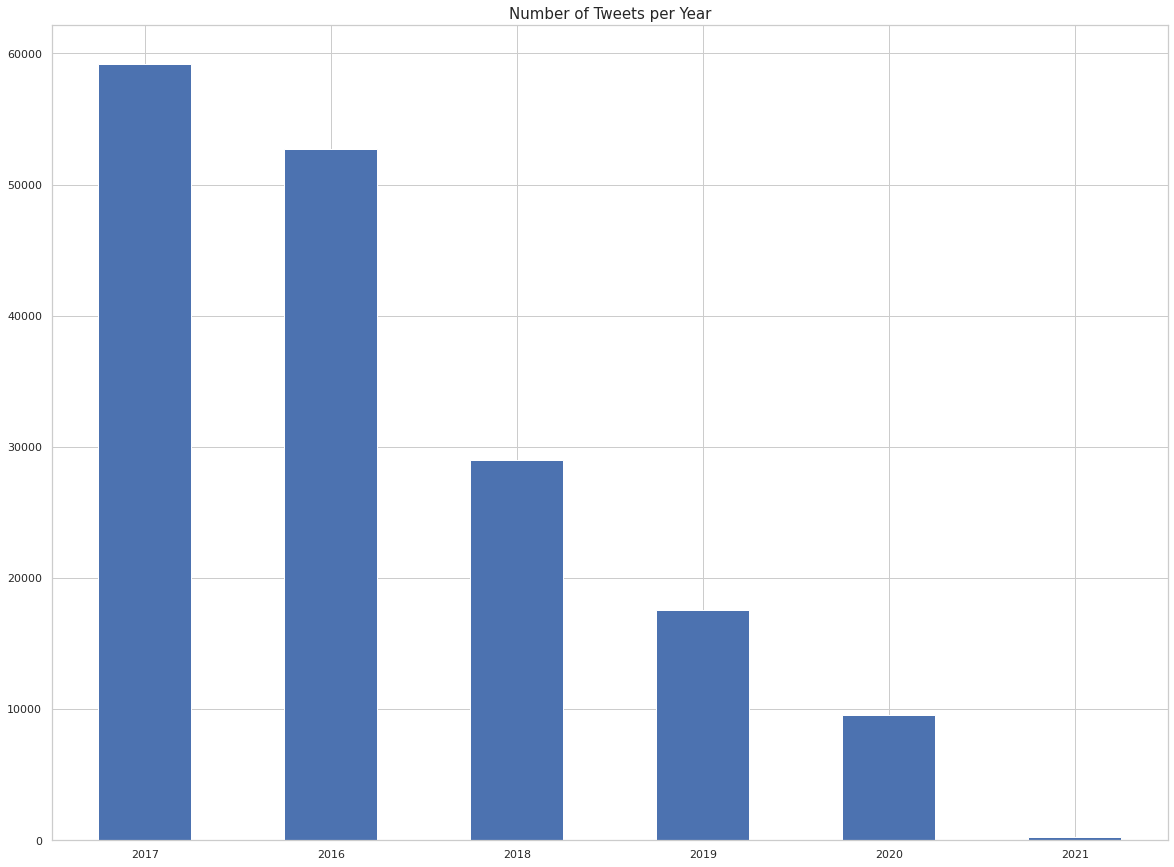

In [3]:
#let's plot the temporal facet : distribution of tweets over the years

sns.set_theme(style = 'whitegrid')
fig,ax =plt.subplots(figsize = (20,15))
df['Year'].value_counts().plot(kind = 'bar')
plt.title("Number of Tweets per Year", size =15)
plt.xticks(rotation=0)


In [4]:
#now let's look at the topical facet : the 5 most popular hashtags

results = Counter()
df['hashtags'].str.lower().str.split(',').apply(results.update)
results.most_common(5)


[('refugees', 16456),
 ('migranti', 14233),
 ('migrants', 12282),
 ('refugeeswelcome', 11789),
 ('muslimban', 10789)]

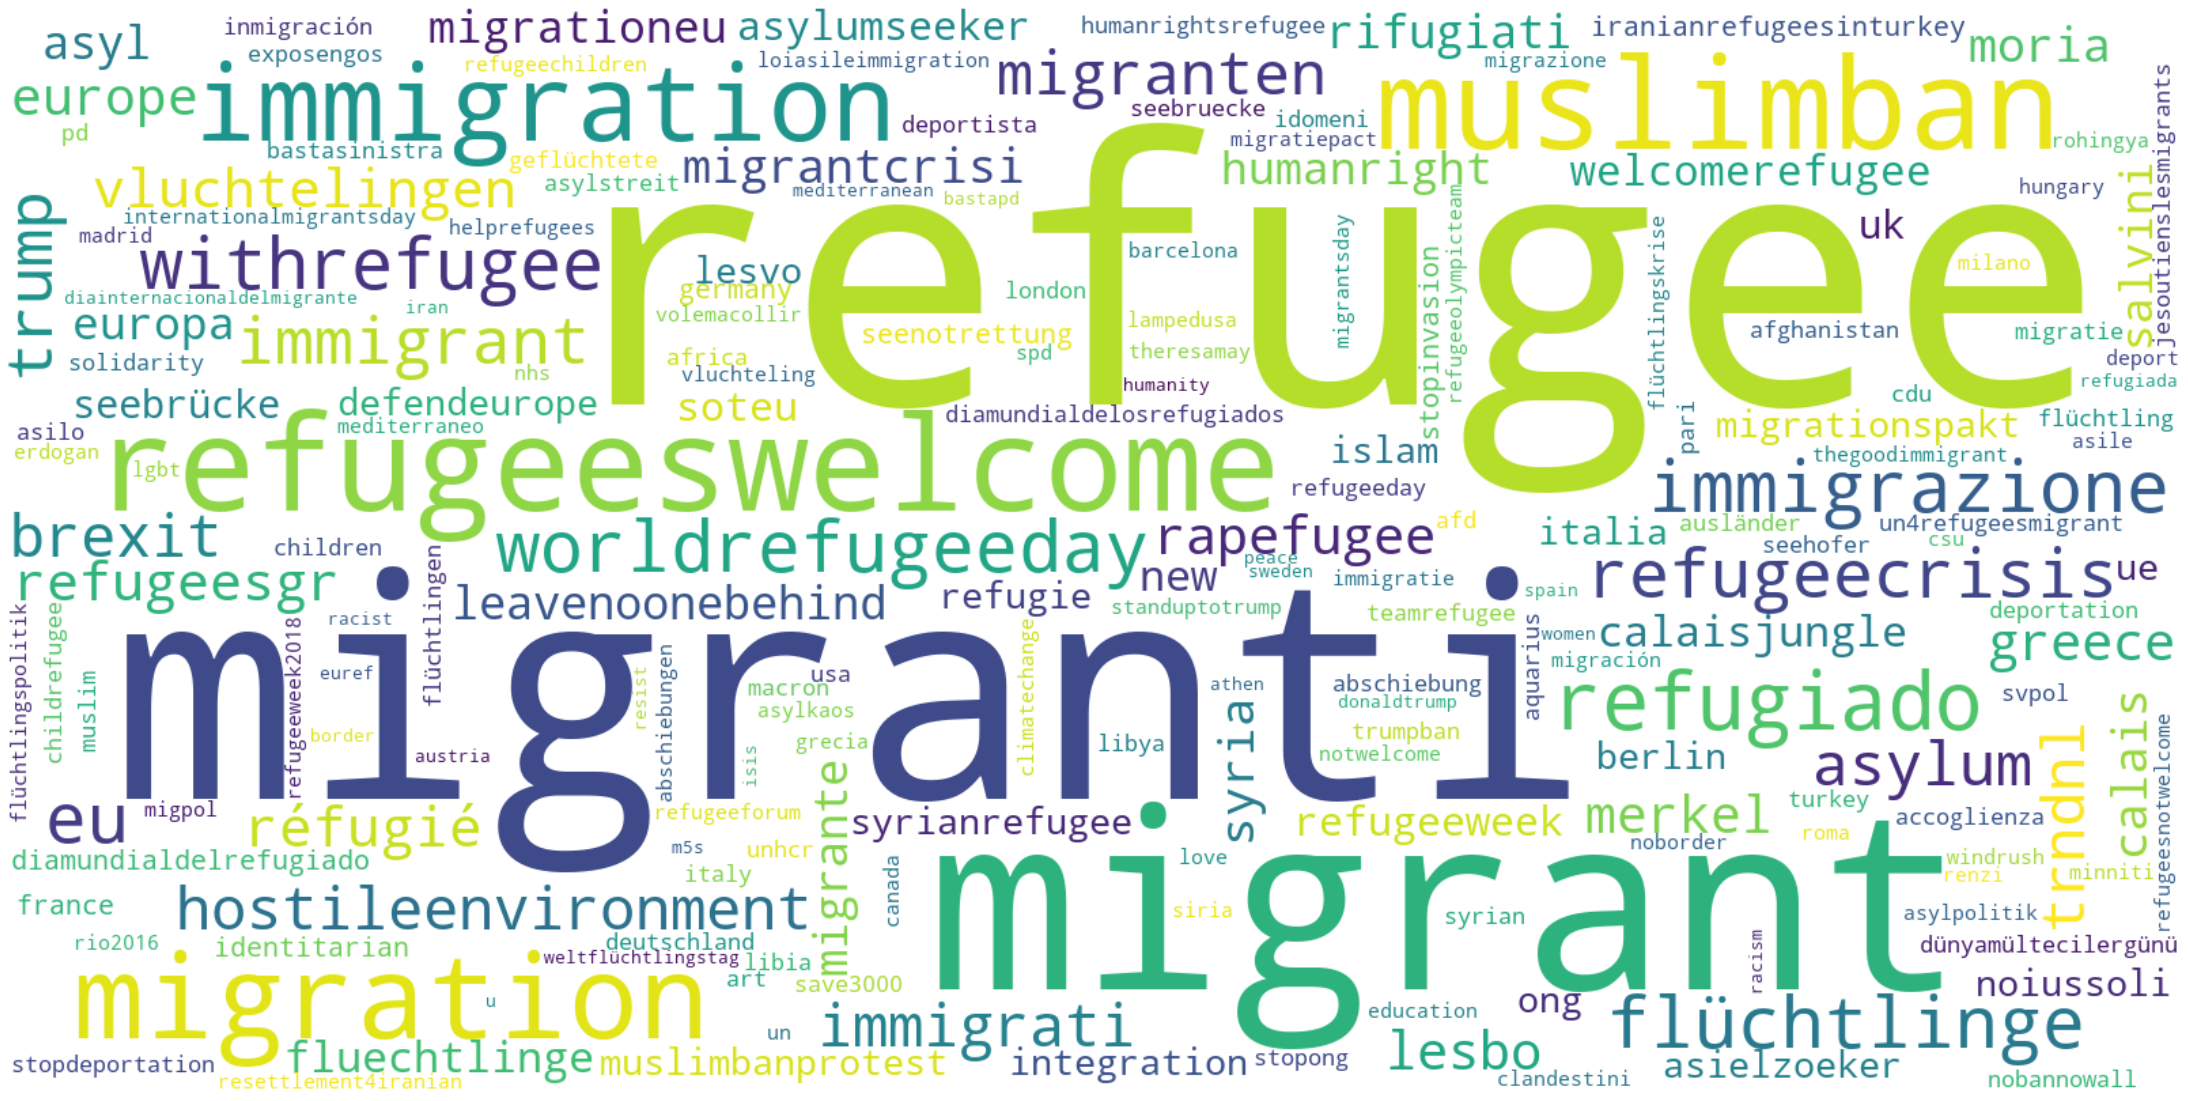

In [5]:
#now let's visualize the results by making a wordcloud of all hashtags in the dataset

def make_wordcloud(newlist):
    
    foo = []
    for item in newlist:
        foo.append(item.lower().split(','))
    flat_list = [item for sublist in foo for item in sublist]
    
    
    text = " ".join(word for word in flat_list)
    stopwords = set(STOPWORDS)
    wordcloud =WordCloud(stopwords=stopwords, 
                   background_color="white", 
                   width=1600, 
                   height=800,
                   contour_width=1,
                   contour_color='black',
                   collocations = False).generate(text)    



    plt.figure(figsize=(40,20))
    plt.tight_layout(pad=0)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
make_wordcloud(df['hashtags'])

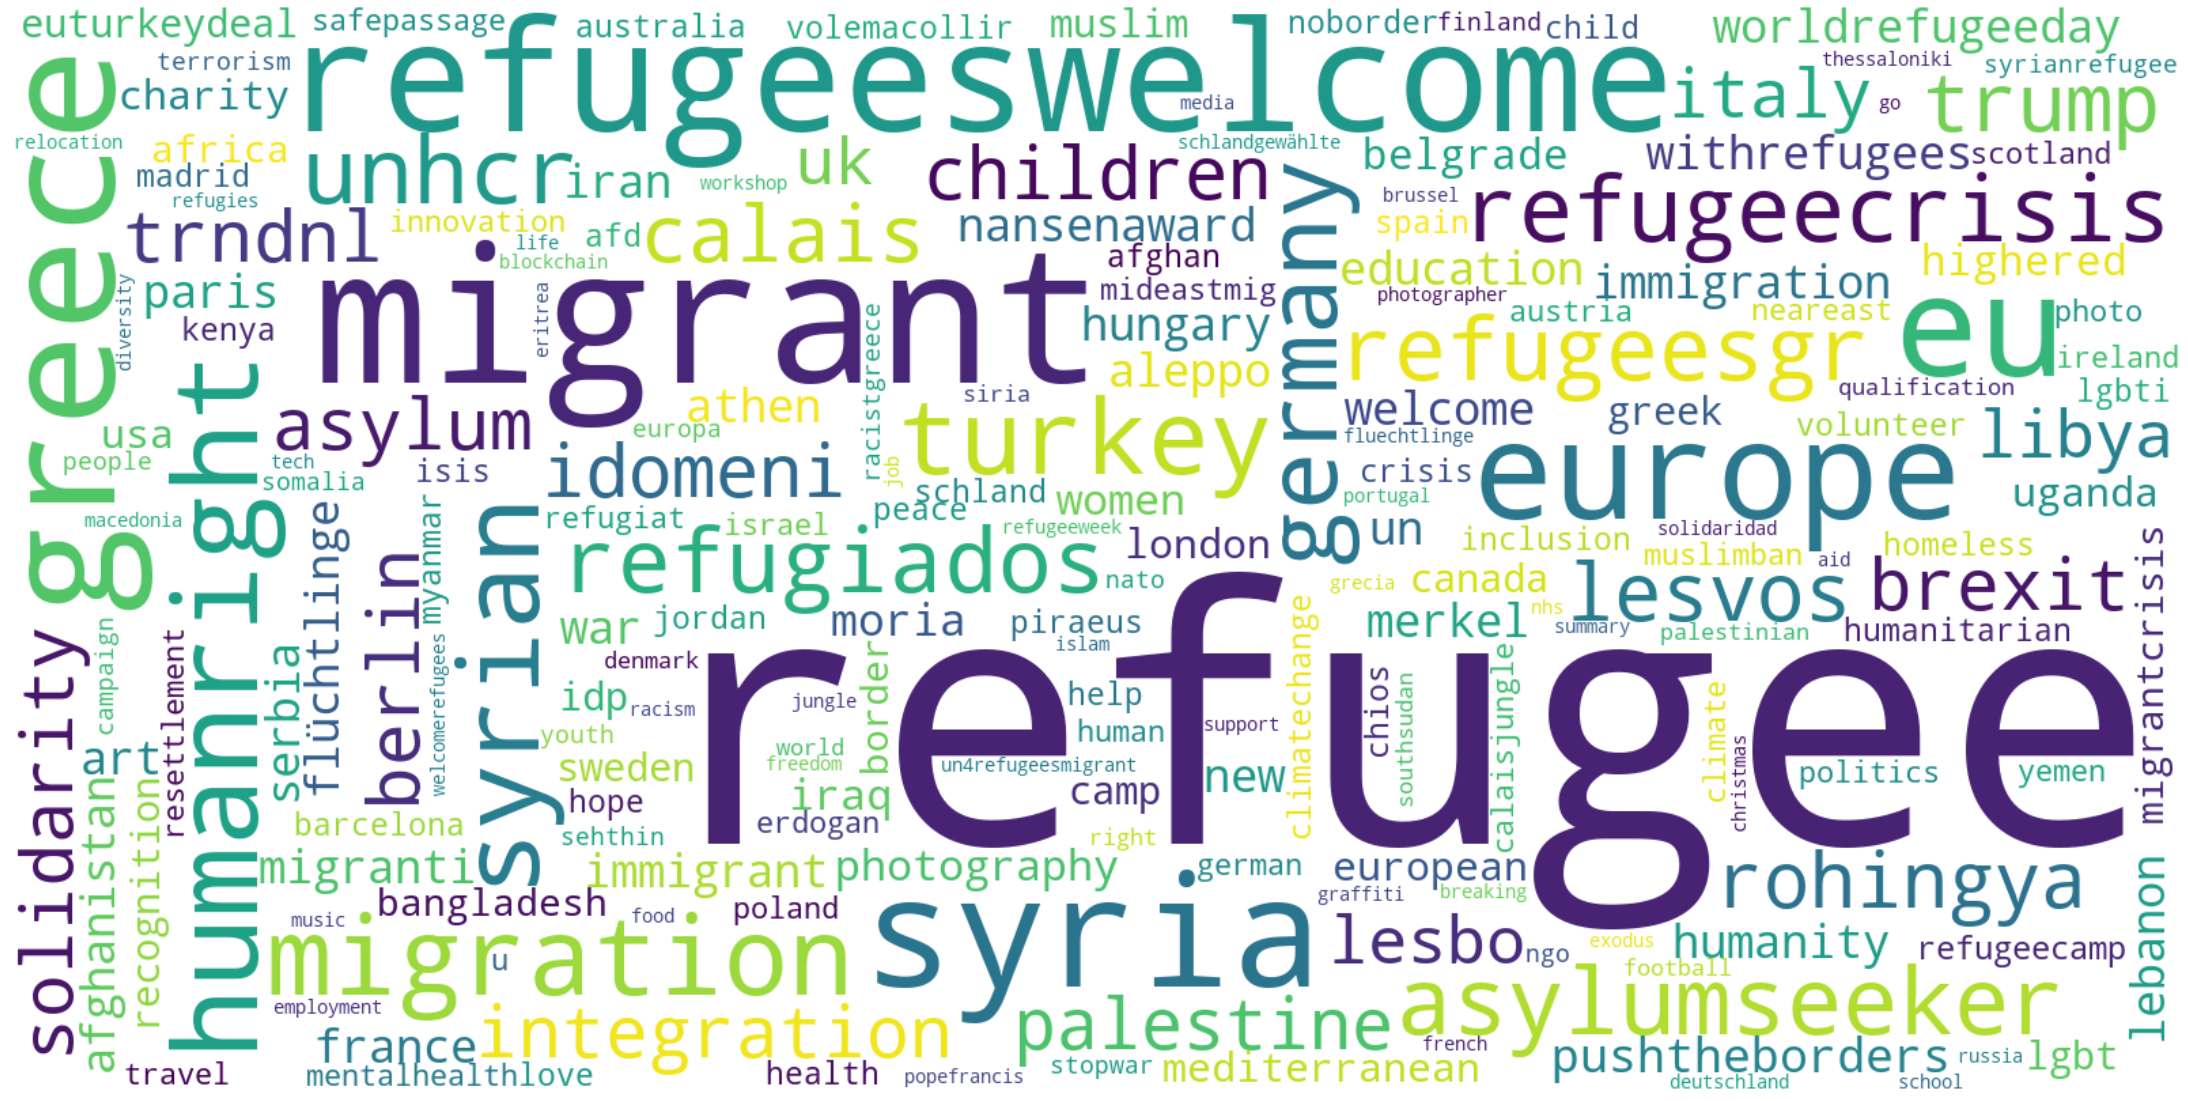

In [6]:
#let's plot the co-occuring hashtags of the hashtag refugees

tag ="refugees"

cloud_plot = df['hashtags'][df["hashtags"].str.contains(f"^({tag})$|^(.*),({tag})$|^(.*),({tag}),(.*)$|^({tag}),(.*)$",
                                                    flags=re.IGNORECASE
                                                    ,regex =True)]

#using regular expressions to find all occurrences of the hashtag refugee

make_wordcloud(cloud_plot)

In [7]:
#let's look at the typicalities of the 5 most popular hashtags

def temporal_hashtag_typicality(year,tag): #function to calculate typicality for hashtags for each year
    
    results_total = Counter()
    results_year = Counter()
    
    df['hashtags'][df['Year']== year].str.lower().str.split(',').apply(results_year.update)
    df['hashtags'].str.lower().str.split(',').apply(results_total.update)
    
    
    freq_total = (results_total[f'{tag}']/sum(results_total.values()))*100
    freq_year = (results_year[f'{tag}']/sum(results_year.values()))*100
    typ =  (freq_year-freq_total)/freq_total
    return typ

tags = {item: [] for item,val in results.most_common(5)} #storing the hashtags in a dictionary as keys

for item in tags.keys():
    for years in range(2016,2022):
        tags[item].append((years,temporal_hashtag_typicality(years,item))) #calculating typicality for each hashtag per year      
        
        
tags #let's look at what we have now

{'refugees': [(2016, 0.2726824345615964),
  (2017, -0.0035173069597875272),
  (2018, -0.3360364161421205),
  (2019, -0.24165387766274085),
  (2020, -0.014188763379531111),
  (2021, -0.005389964007439301)],
 'migranti': [(2016, -0.40937402139688156),
  (2017, 0.08739384143690297),
  (2018, 0.3668482094729229),
  (2019, 0.4558012981365529),
  (2020, -0.25513664505309336),
  (2021, -0.13753410635704447)],
 'migrants': [(2016, 0.19032044615378083),
  (2017, -0.16545452937560845),
  (2018, 0.030315462571939567),
  (2019, -0.02227445402801649),
  (2020, -0.09446990797802236),
  (2021, -0.20042487775800788)],
 'refugeeswelcome': [(2016, 0.3942390560824832),
  (2017, -0.0682800069018937),
  (2018, -0.2971318790510198),
  (2019, -0.4623988511961949),
  (2020, -0.015879645407150318),
  (2021, 0.04126533753670238)],
 'muslimban': [(2016, -0.9958991470096452),
  (2017, 1.8125234631538671),
  (2018, -0.9796517803184179),
  (2019, -0.9781759832443213),
  (2020, -0.9888758395105854),
  (2021, -0.9241

In [8]:
"""Every hashtag now has the year and the typicality for that year stored in the dictionary.
This is however not very useful for plotting. Let's separate the years and values into a 
pandas dataframe so that we can plot them."""

dummy=pd.DataFrame.from_dict(tags,orient='index').transpose()

def remove_years(x):
        return x[0]
def remove_years1(x):
        return x[1]    

dummy['Years'] = dummy['refugees'].apply(lambda x:remove_years(x)).apply(pd.Series)


for item in tags.keys():
    dummy[f'{item}'] = dummy[f'{item}'].apply(lambda x:remove_years1(x)).apply(pd.Series)


dummy #let's look at the dataframe now

,refugees,migranti,migrants,refugeeswelcome,muslimban,Years
0,0.272682,-0.409374,0.190320,0.394239,-0.995899,2016
1,-0.003517,0.087394,-0.165455,-0.068280,1.812523,2017
2,-0.336036,0.366848,0.030315,-0.297132,-0.979652,2018
3,-0.241654,0.455801,-0.022274,-0.462399,-0.978176,2019
4,-0.014189,-0.255137,-0.094470,-0.015880,-0.988876,2020
5,-0.005390,-0.137534,-0.200425,0.041265,-0.924148,2021


In [9]:
"""So now the years and values are separated, but this form will lead to a strange plot.
We need the hashtags as variables on which the color will be applied on the grouped 
bar chart. This can be performed simply with the melt pandas method. """


dummy = dummy.melt("Years", var_name ='hashtags',value_name = 'typicality')
dummy


,Years,hashtags,typicality
0,2016,refugees,0.272682
1,2017,refugees,-0.003517
2,2018,refugees,-0.336036
3,2019,refugees,-0.241654
4,2020,refugees,-0.014189
5,2021,refugees,-0.005390
6,2016,migranti,-0.409374
7,2017,migranti,0.087394
8,2018,migranti,0.366848
9,2019,migranti,0.455801


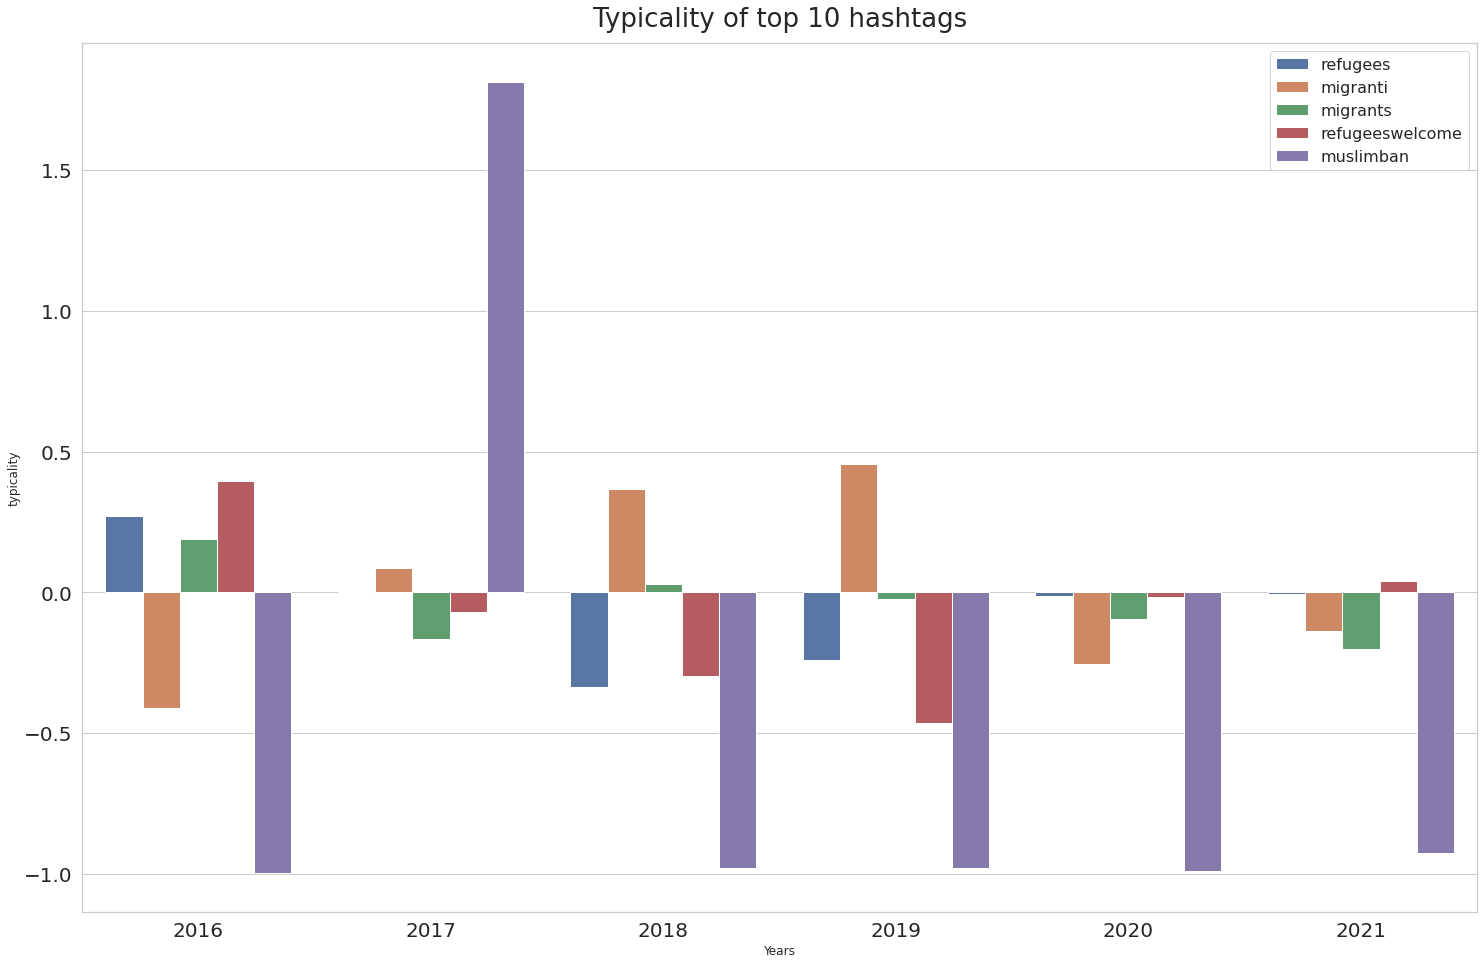

In [10]:
#And finally the grouped bar chart!! 


sns.set_theme(style ='whitegrid')
fig,ax = plt.subplots(1,figsize =(25,16))
sns.barplot(data = dummy, y ='typicality' , hue ='hashtags', x ="Years",ax =ax)
ax.set(ylabel = "typicality")
ax.get_legend().remove()
plt.legend(loc=1, prop={'size': 16})
plt.title("Typicality of top 10 hashtags",pad =16.0, size =26)
ax.tick_params(axis='both', which='major', labelsize=20)


In [11]:
"""Let's make a plot involving both the spatial and temporal facet. For that we will use a geojson file.
This file has a column (name) which says which countries, the tweets were tweeted from. This was created using a sptial join
similar to the one in HLL_grid_map.ipynb"""

gj = gp.read_file(OUTPUT / "countries.geojson")

gj['post_publish_date'] = pd.to_datetime(gj['post_publish_date']) 
gj['Month/Year'] = gj['post_publish_date'].dt.to_period('M')
gj['Year'] = gj['post_publish_date'].dt.year
gj.drop(columns = ['post_guid'],inplace = True)
gj

#let's take a look. Notice that there are lesser tweets here as compared to the original csv imported at the start of this file.

,post_body,post_publish_date,post_language,hashtags,emoji,name,Month/Year,geometry,Year
0,L’esercito silenzioso delle #donne #migranti h...,2017-01-18 11:56:38,it,"migranti,donne",,Italy,2017-01,POINT (9.15934 45.46135),2017
1,".@lauraravetto: #Migranti, “Che dice Minniti s...",2017-01-18 12:09:43,it,Migranti,,Italy,2017-01,POINT (12.54515 41.89842),2017
2,#refugeecrisis https://t.co/JQoSFvMTbl,2017-01-18 12:06:31,und,refugeecrisis,,Portugal,2017-01,POINT (-8.62191 41.16214),2017
3,".@lauraravetto : #Migranti, “Che dice Minniti ...",2017-01-18 12:07:41,it,Migranti,,Italy,2017-01,POINT (12.54515 41.89842),2017
4,""".@theresa_may: '""We can still have EU workers...",2017-01-18 12:17:35,en,"Brexit,PMQs,immigration",,United Kingdom,2017-01,POINT (-2.11587 53.07371),2017
...,...,...,...,...,...,...,...,...,...
156143,#terremoto visto che dobbiamo far lavorare #im...,2017-01-18 11:04:04,it,"terremoto,immigrati",😠,Italy,2017-01,POINT (8.80651 45.83137),2017
156144,""". @JunckerEU '""We want to get rid of this id...",2017-01-18 11:05:00,en,"terrorism,Juncker,migration",,Belgium,2017-01,POINT (4.47677 50.50117),2017
156145,#RussianDissident Artist Will Seek #Asylum in ...,2017-01-18 11:17:53,en,"RussianDissident,Asylum",🇫🇷,Spain,2017-01,POINT (-3.70351 40.47779),2017
156146,Just caught this sight out of my bedroom windo...,2017-01-18 11:30:09,en,"Victory,Birds,Gaggle,VFlight,Margate,Geese,Mig...",😊,United Kingdom,2017-01,POINT (1.35792 51.37948),2017


In [12]:
"""To capture both the facets together, we use a pandas function called groupby, which is very similar to the SQL GROUP BY operation"""

spatio_temporal = gj.groupby(['Month/Year', 'name']).size()
spatio_temporal

Month/Year  name          
2016-03     Belgium            3
            France             3
            Germany            8
            Italy              1
            Macedonia          1
                              ..
2021-01     Spain             16
            Sweden             3
            Switzerland        3
            Turkey             1
            United Kingdom    34
Length: 1793, dtype: int64

In [13]:
"""Now we have for every month, the number of tweets from every country. This can be plotted simultaneously with a bit of effort"""


#first let's store the data for every country in a variable

uk = spatio_temporal.xs("United Kingdom",level="name")
it = spatio_temporal.xs("Italy",level="name")
de = spatio_temporal.xs("Germany",level="name")
esp = spatio_temporal.xs("Spain",level="name")
fr = spatio_temporal.xs("France",level="name")
net = spatio_temporal.xs("Netherlands",level="name")

#let's take a look at how these variables are set-up

uk


Month/Year
2016-03       5
2016-04    1351
2016-05    1283
2016-06    2686
2016-07    1289
2016-08    1114
2016-09    1627
2016-10    1774
2016-11     905
2016-12     797
2017-01    6733
2017-02    2025
2017-03    1072
2017-04     659
2017-05     845
2017-06    1484
2017-07     683
2017-08     549
2017-09     724
2017-10     590
2017-11     445
2017-12     365
2018-01     340
2018-02     281
2018-03     365
2018-04     592
2018-05     418
2018-06    1217
2018-07     445
2018-08     372
2018-09     346
2018-10     402
2018-11     262
2018-12     595
2019-01     452
2019-02     331
2019-03     317
2019-04     195
2019-05     222
2019-06     685
2019-07     279
2019-08     260
2019-09     275
2019-10     267
2019-11     298
2019-12     210
2020-01     171
2020-02     331
2020-03     283
2020-04      25
2020-05     207
2020-06     431
2020-07     102
2020-08     336
2020-09      93
2020-10      45
2020-12     122
2021-01      34
Freq: M, dtype: int64

<AxesSubplot:title={'center':'NET'}, xlabel='Month/Year'>

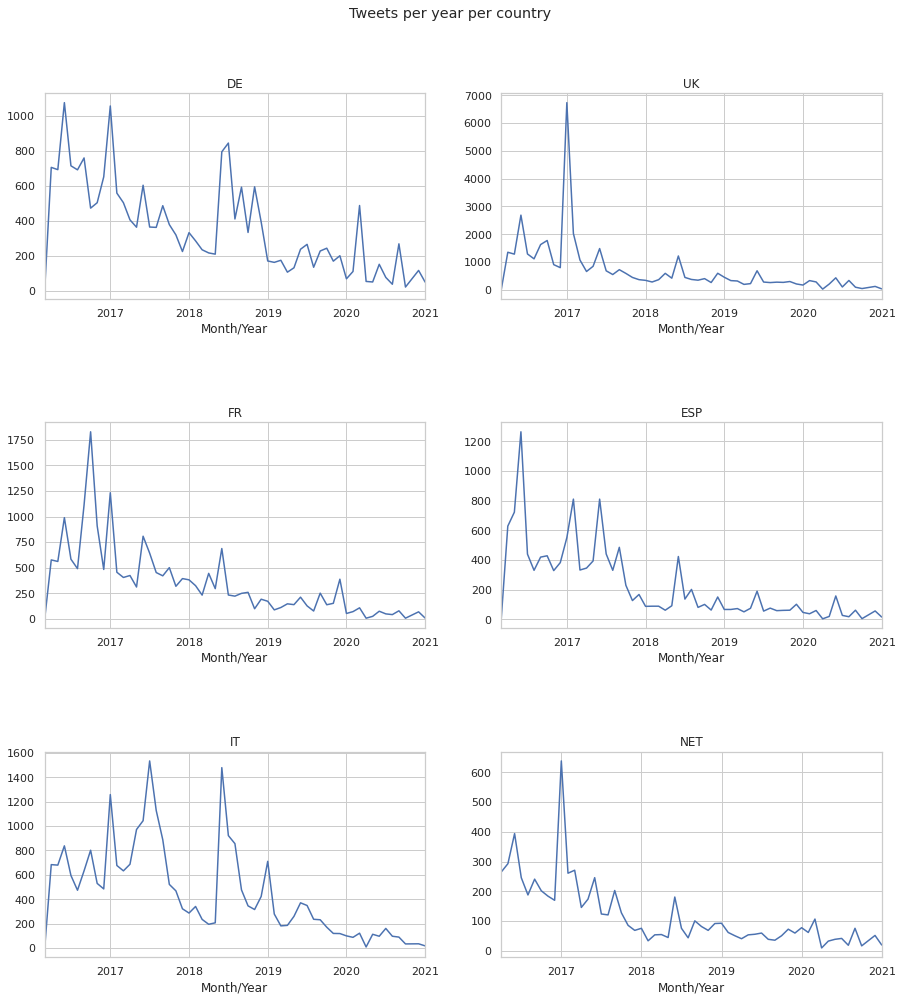

In [14]:
"""Since every variable has the months and the number of posts with them, we can feed each variable to an axis and plot them!"""

#setting up the axes

fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(ncols =2, nrows=3,figsize=(15,15))
fig.suptitle('Tweets per year per country')
fig.tight_layout()
plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
                    right = 0.9,    # the right side of the subplots of the figure
                    bottom = 0.1,   # the bottom of the subplots of the figure
                    top = 0.9,      # the top of the subplots of the figure
                    wspace = 0.2,   # the amount of width reserved for blank space between subplots
                    hspace = 0.6,
                   )

ax1.title.set_text('DE')
ax2.title.set_text('UK')
ax3.title.set_text('FR')
ax4.title.set_text('ESP')
ax5.title.set_text('IT')
ax6.title.set_text('NET')

#feeding the axes with the variables 

de.plot(ax=ax1)
uk.plot(ax=ax2)
fr.plot(ax=ax3)
esp.plot(ax=ax4)
it.plot(ax=ax5)
net.plot(ax=ax6)

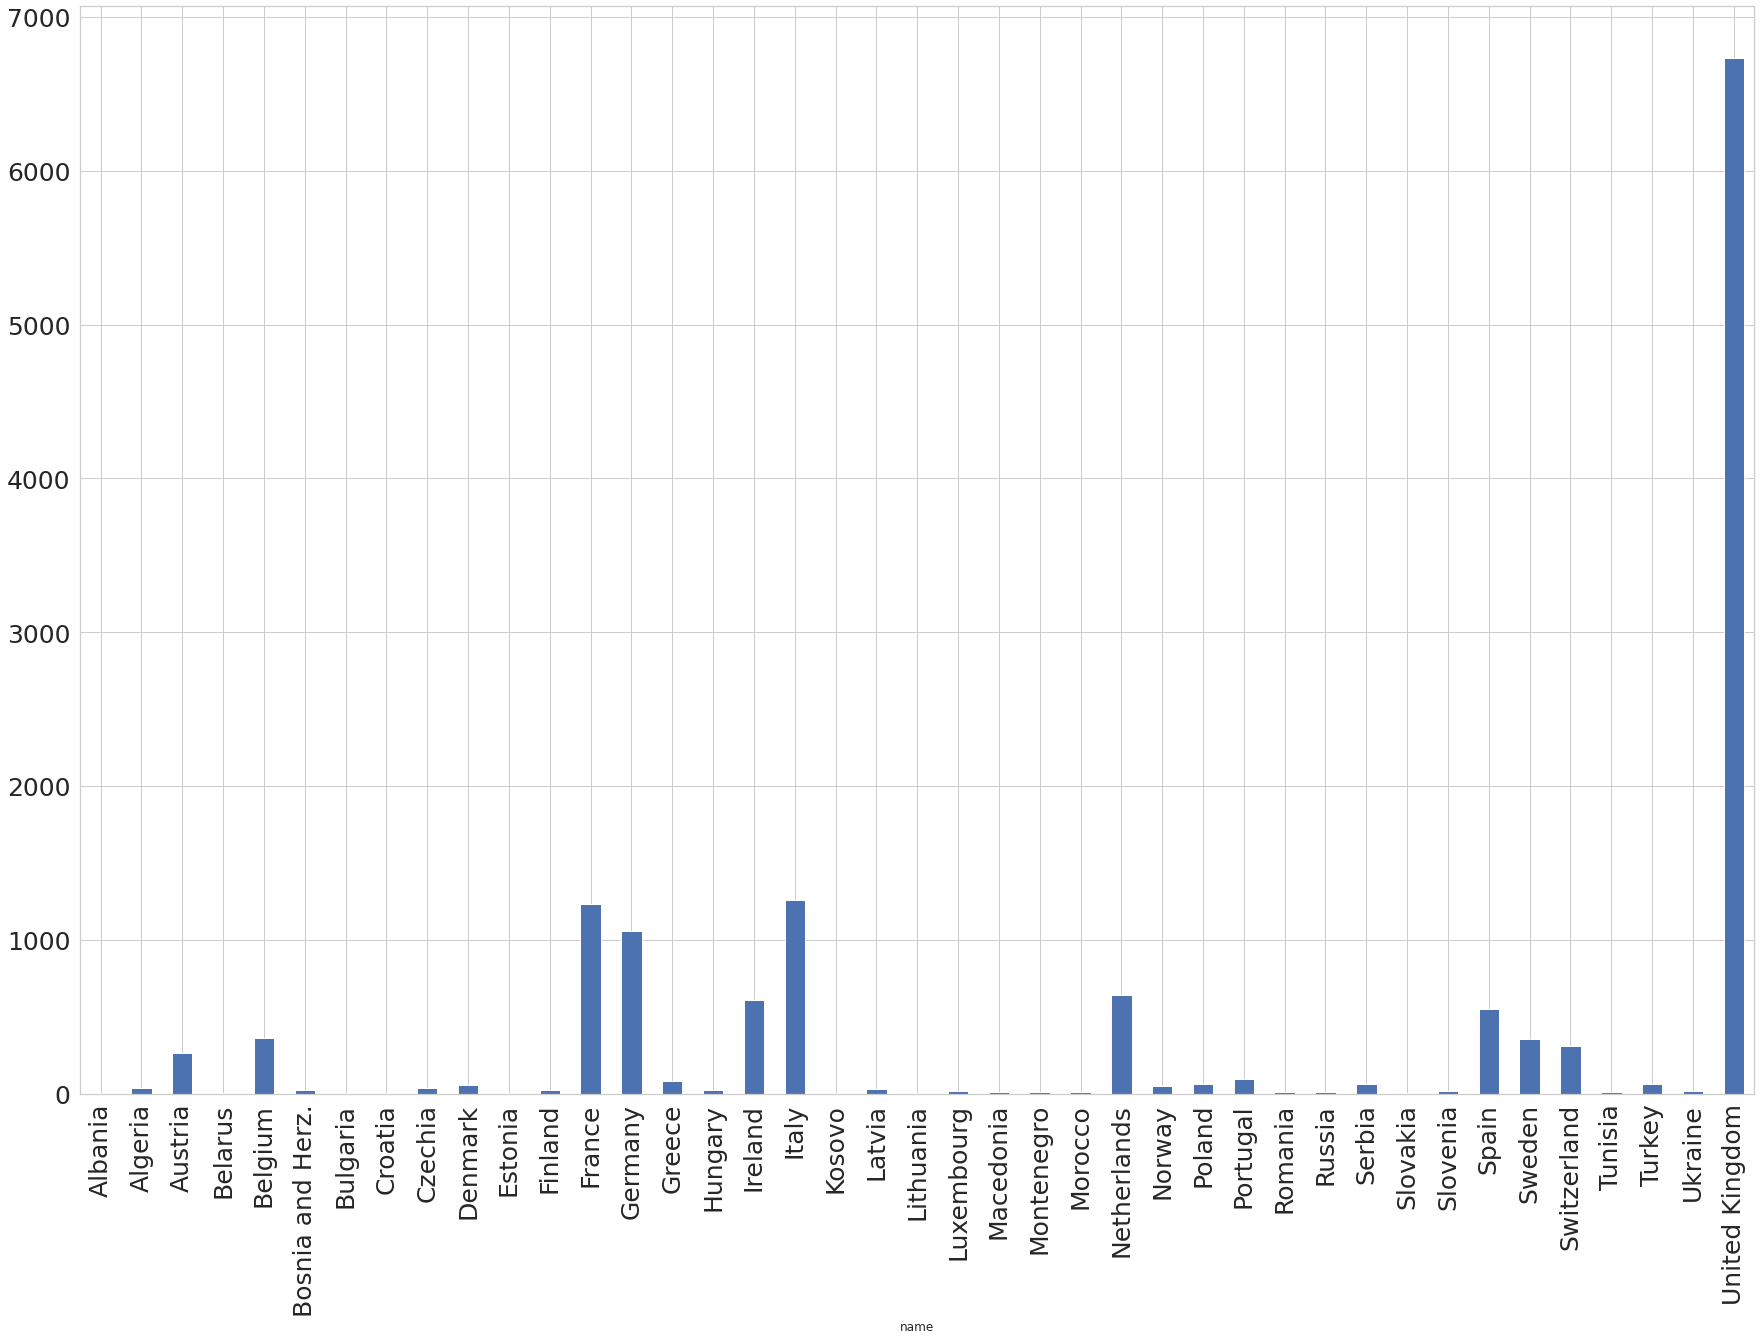

In [15]:
"""We can also quickly switch from the temporal to the spatial facet and select a month to see the number of tweets per country"""

fig,ax = plt.subplots(1,figsize = (30,20) )
spatio_temporal.xs("2017-01",level="Month/Year").plot(kind = "bar")  #showing the number of tweets for January 2017
ax.tick_params(axis='both', which ='major', labelsize =25)


In [16]:
"""Let's use the Vader Sentiment library, for a sentiment analysis of the english tweets"""

df_sent = df[df['post_language']== 'en']
analyzer = SentimentIntensityAnalyzer()

df_sent[['neg', 'neu', 'pos', 'compound']] = df_sent['post_body'].apply(analyzer.polarity_scores).apply(pd.Series)
df_sent.head()

,long,lat,post_body,post_publish_date,post_language,hashtags,emoji,geometry,Month/Year,Year,neg,neu,pos,compound
4,-2.115866,53.073712,""".@theresa_may: '""We can still have EU workers...",2017-01-18 12:17:35,en,"Brexit,PMQs,immigration",None,POINT (-2.11587 53.07371),2017-01,2017,0.000,1.000,0.000,0.0000
7,14.380054,35.934249,Throwing more money will not solve #migration ...,2017-01-18 12:19:19,en,"EU2017MT,migration",None,POINT (14.38005 35.93425),2017-01,2017,0.115,0.648,0.237,0.4023
8,9.818380,46.764999,Syrian refugee @YusraMardini speaking at a #we...,2017-01-18 12:27:15,en,"wef17,TeamRefugees",None,POINT (9.81838 46.76500),2017-01,2017,0.000,1.000,0.000,0.0000
9,20.834226,39.655955,#Refugee kids from the accommodation site of V...,2017-01-18 12:34:27,en,Refugee,None,POINT (20.83423 39.65596),2017-01,2017,0.000,1.000,0.000,0.0000
10,4.577031,52.294800,I'm afraid @CroissantRouge volunteers in #Tuni...,2017-01-18 13:07:08,en,"Tunisia,migrants,refugees",None,POINT (4.57703 52.29480),2017-01,2017,0.000,1.000,0.000,0.0000


<AxesSubplot:xlabel='Year', ylabel='compound'>

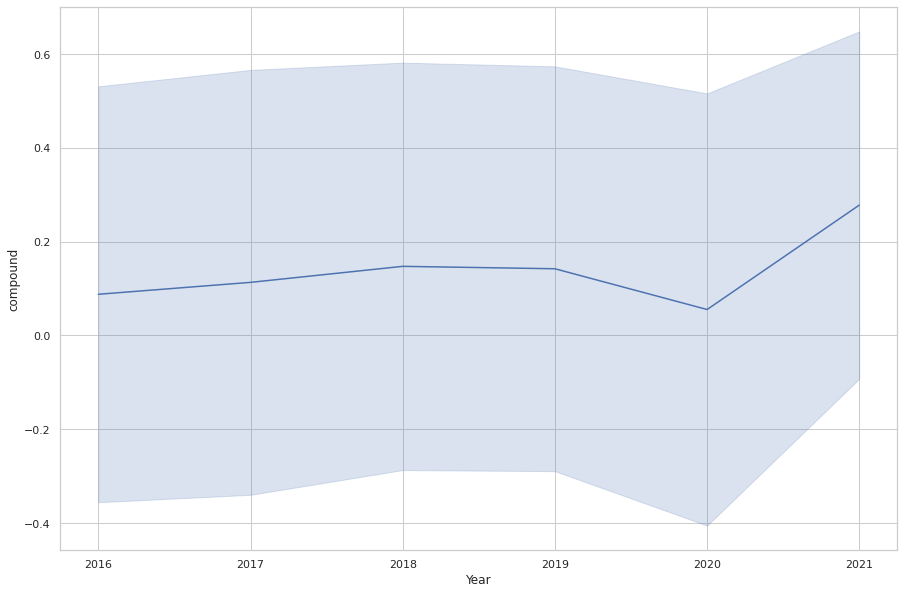

In [18]:
"""Let's plot the compund score (combination of negative, neutral and positive score) for the hashtag refugee.
The region in blue indicates the standard deviation of the compund values."""


tag ="refugees"
refugees = df_sent[df_sent["hashtags"].str.contains(f"^({tag})$|^(.*),({tag})$|^(.*),({tag}),(.*)$|^({tag}),(.*)$",
                                                    flags=re.IGNORECASE
                                                    ,regex =True)]
plt.figure(figsize=(15,10))
sns.lineplot(data = refugees, x = "Year", y = "compound", ci ="sd")